In [64]:
import os, sys, email
import numpy as np
import pandas as pd
import nltk
from nltk.metrics import *
import pprint, re, time

pd.options.display.max_colwidth = 1000

In [ ]:
# 自然言語処理
import stanza
#stanza.download('en')
nlp = stanza.Pipeline('en')

In [3]:
from loadFile import getFileList, getDirList, fileToDataFrame

# ディレクトリ 内のメールファイルを読み込む
directory_path = "wiki-research-l/2020-July"
file_list = getFileList(directory_path)
file_list.sort()

# テキストファイルをデータフレームに格納する
mail_df, thread_df = fileToDataFrame(file_list)

In [4]:
# メールのBody部分を各パートに分解する
bodies = dict(Bodies=[])
for idx, body in mail_df.loc[:,'Body'].items():
    origin = []
    greetings = dict(Greetings=[])
    sentences = dict(Sentence=[])
    captions = dict(Caption=[])
    bulletlist = dict(Bulletlist=[])
    ending = dict(Ending=[])
    quotation = dict(Quotation=[])
    footer = dict(Footer=[])
    misc = dict(Misc=[])

    lines = body.splitlines()
    for num, line in enumerate(lines):
        if re.match(r'\[G\]',line) is not None:
            greetings['Greetings'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[S\]',line) is not None:
            sentences['Sentence'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[C\]',line) is not None:
            captions['Caption'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[B\]',line) is not None:
            bulletlist['Bulletlist'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[E\]',line) is not None:
            ending['Ending'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[Q\]',line) is not None:
            quotation['Quotation'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[F\]',line) is not None:
            footer['Footer'].append({num:line[3:]})
            origin.append(line[3:])
        elif re.match(r'\[M\]',line) is not None:
            misc['Misc'].append({num:line[3:]})
            origin.append(line[3:])
        else: #空白行に対応する
            continue
    originbody = re.sub(r'\[(G|S|C|B|E|Q|F|M)\]', '', body)
    bodies['Bodies'].append({'idx':idx, 'message_id':mail_df['Message-ID'][idx], 'countrows':len(lines), 'body':originbody, **greetings, **sentences, **captions, **bulletlist, **ending, **quotation, **footer, **misc})

In [45]:
# mail_dfのFromからEntityを取得する

sender_dict = {}

for address_sender in mail_df['From'].values:
    start = re.search(r'(\(.+\))',address_sender).start()
    end = re.search(r'(\(.+\))',address_sender).end()
    # 取得するEntityはメールアドレスと送信者の2種類
    address = address_sender[0:start-1]
    sender = address_sender[start+1:end-1]
    sender_dict.setdefault(address,{address:"MAIL"})
    sender_dict.setdefault(sender,{sender:"PERSON"})

In [46]:
# mail_dfのDateからEntityを取得する

date_dict = {}

for date in mail_df['Date'].values:
    date = re.match(r'(\w{3}, \d{1,2} \w{3} \d{4})',date)
    date_dict[date.group()] = {date.group():"DATE"}

In [47]:
entity_dict = dict(**sender_dict, **date_dict)
entity_dict

{'ziningy1 at andrew.cmu.edu': {'ziningy1 at andrew.cmu.edu': 'MAIL'},
 'Ethan Ye': {'Ethan Ye': 'PERSON'},
 'glc3 at mail.usf.edu': {'glc3 at mail.usf.edu': 'MAIL'},
 'Giovanni Luca Ciampaglia': {'Giovanni Luca Ciampaglia': 'PERSON'},
 'masssly at ymail.com': {'masssly at ymail.com': 'MAIL'},
 'Mohammed Sadat Abdulai': {'Mohammed Sadat Abdulai': 'PERSON'},
 'natematias at gmail.com': {'natematias at gmail.com': 'MAIL'},
 'J. Nathan Matias': {'J. Nathan Matias': 'PERSON'},
 'miriam at wikimedia.org': {'miriam at wikimedia.org': 'MAIL'},
 'Miriam Redi': {'Miriam Redi': 'PERSON'},
 'mackenzie.lemieux at gmail.com': {'mackenzie.lemieux at gmail.com': 'MAIL'},
 'Mackenzie Lemieux': {'Mackenzie Lemieux': 'PERSON'},
 'lzia at wikimedia.org': {'lzia at wikimedia.org': 'MAIL'},
 'Leila Zia': {'Leila Zia': 'PERSON'},
 'jlayton at wikimedia.org': {'jlayton at wikimedia.org': 'MAIL'},
 'Janna Layton': {'Janna Layton': 'PERSON'},
 'aaron.halfaker at gmail.com': {'aaron.halfaker at gmail.com': 'MAI

In [48]:
total_start = time.time()
# Bodyに含まれる文をEntity linkerにかけて辞書を作成する．

from entityLinking import tagme

for mail in bodies['Bodies']:
    body = re.sub(r'\n{2,}','\n',mail['body'])
    body = re.sub(r'\n{1}',' ',body)
    body = re.sub(r'( >){1,}','',body)
    body = re.sub(r'\*{1,}','',body)
    body = re.sub(r'(On)','. On',body)
    doc = nlp(body)
    
    part_start = time.time()

    for sentence in doc.sentences:
        json_res = tagme(sentence.text)
        linked_entities = [annotation for annotation in json_res['annotations'] if annotation['rho'] > 0.3]
        if linked_entities != []:
            for le in linked_entities:
                spot = le['spot']
                entity_dict.setdefault(spot,{le['title']:le['id']})

    part_time = time.time() - part_start
    print("Partial time:{}".format(part_time))

total_time = time.time() - total_start
print("Total time:{}".format(total_time))

Partial time:61.21891713142395
Partial time:90.24923801422119
Partial time:23.854049921035767
Partial time:13.604794025421143
Partial time:33.914835929870605
Partial time:18.102203845977783
Partial time:16.462202787399292
Partial time:31.510234117507935
Partial time:59.34912896156311
Partial time:48.19494986534119
Partial time:37.49989295005798
Partial time:70.1837649345398
Partial time:45.16007399559021
Partial time:155.96255326271057
Partial time:22.585543870925903
Partial time:183.80331301689148
Partial time:9.423819065093994
Partial time:192.8061969280243
Partial time:19.37337327003479
Partial time:70.029465675354
Partial time:62.34679388999939
Partial time:91.18311095237732
Partial time:18.77285599708557
Partial time:19.982100248336792
Partial time:31.09875798225403
Partial time:11.093640089035034
Partial time:6.513888120651245
Partial time:18.829880952835083
Partial time:34.97470688819885
Partial time:43.7759108543396
Partial time:29.585386037826538
Partial time:22.61622500419616

In [51]:
import pickle

with open("wiki-research-l/output/entity_dict.pkl","wb") as f:
    pickle.dump(entity_dict, f)

In [115]:
# entity_dictに登録のないNamed Entityを確認する
ne_dict = {}
for mail in bodies['Bodies']:
    body = re.sub(r'\n{2,}','\n',mail['body'])
    body = re.sub(r'\n{1}',' ',body)
    body = re.sub(r'( >){1,}','',body)
    body = re.sub(r'\*{1,}','',body)
    body = re.sub(r'(On)','. On',body)
    doc = nlp(body)
    for ent in doc.ents:
        if ent.type not in ('TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'CARDINAL', 'ORDINAL'):
            ent = ent.to_dict()
            if ent["text"].lower() in list(map(lambda x:x.lower(),entity_dict.keys())):
                pass
            else:
                ne_dict[ent["text"]] = ent["type"]
pprint.pprint(ne_dict)
print(len(ne_dict))

{'#wikimedia': 'ORG',
 '--  Cyril Verluise': 'PERSON',
 '--  Isaac Johnson': 'PERSON',
 '--  J. Nathan Matias': 'PERSON',
 '-- Isaac Johnson': 'PERSON',
 '10 Jul 2020': 'DATE',
 '10 years': 'DATE',
 '12 Jul 2020': 'DATE',
 '1–10, 2011': 'DATE',
 '2 August': 'DATE',
 '20 | 50 | 100 | 250 | 500': 'DATE',
 '2007': 'DATE',
 '2011': 'DATE',
 '2014': 'DATE',
 '2016': 'DATE',
 '2020': 'DATE',
 '2020 Camera': 'WORK_OF_ART',
 '2278 - 1307': 'DATE',
 '23:59 PM': 'DATE',
 '29 Jun 2020': 'DATE',
 '2nd Conference on Truth and Trust': 'ORG',
 '50': 'DATE',
 'A Quantitative Portrait of Wikipedia\'s High-Tempo Collaborations during the 2020 Coronavirus Pandemic"4.2 COVID-19': 'WORK_OF_ART',
 'AFD': 'ORG',
 'AI': 'ORG',
 'AIRCCSE': 'ORG',
 'AIRCCSE.ORG': 'ORG',
 'Aaron': 'PERSON',
 'Abstract Wikipedia': 'WORK_OF_ART',
 'Administrative Assistant - Product & Technology Wikimedia Foundation': 'ORG',
 'Aidan Hogan': 'PERSON',
 'Akhil Arora': 'PERSON',
 'Alberto García Durán': 'PERSON',
 'Alessandro Piscopo

In [146]:
with open("wiki-research-l/output/ne_dict.pkl","wb") as f:
    pickle.dump(ne_dict, f)

In [61]:
nltk.download('stopwords')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taroaso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [116]:
# 名寄せ
add_entity_dict = {}
for ne in ne_dict.keys():
    ne_tokens = ne.split()
    threshold = 0.5
    filtered_ne_tokens = [token for token in ne_tokens if token not in stop_words]
    filtered_ne_tokens = set(list(map(str.lower, filtered_ne_tokens)))
    for spot in entity_dict.keys():
        # jaccard distance
        spot_tokens= spot.split()
        filtered_spot_tokens = [token for token in spot_tokens if token not in stop_words]
        filtered_spot_tokens = set(list(map(str.lower,filtered_spot_tokens)))
        jd = jaccard_distance(filtered_ne_tokens, filtered_spot_tokens)
        # edit distance
        filtered_spot = ' '.join(filtered_spot_tokens)
        filtered_ne = ' '.join(filtered_ne_tokens)
        ed = edit_distance(filtered_spot, filtered_ne)/max(len(filtered_spot),len(filtered_ne))
        if min(jd,ed) < threshold:
            threshold = min(jd,ed)
            add_entity_dict[ne] = entity_dict[spot]
pprint.pprint(add_entity_dict)
print(len(add_entity_dict))

{'#wikimedia': {'Wikimedia Foundation': 18618509},
 '--  Cyril Verluise': {'cyril verluise': 'PERSON'},
 '--  Isaac Johnson': {'Isaac Johnson': 'PERSON'},
 '--  J. Nathan Matias': {'J. Nathan Matias': 'PERSON'},
 '-- Isaac Johnson': {'Isaac Johnson': 'PERSON'},
 '10 Jul 2020': {'Fri, 10 Jul 2020': 'DATE'},
 '12 Jul 2020': {'Sun, 12 Jul 2020': 'DATE'},
 '29 Jun 2020': {'Mon, 27 Jul 2020': 'DATE'},
 'AI': {'Application programming interface': 27697009},
 'Abstract Wikipedia': {'Wikimedia project': 400529},
 'Ethan) Ye Carnegie Mellon University': {'Carnegie Mellon University': 48093},
 'Google': {'Google Search': 12431},
 'Google - Andrew D. Gordon': {'Andrew D. Gordon': 147650},
 'Haifeng': {'Haifeng Zhang': 'PERSON'},
 'Haifeng Zhang"': {'Haifeng Zhang': 'PERSON'},
 'Hindi': {'H-index': 3604693},
 'Images in Wikipedia': {'Wikipedia': 5043734},
 'Jul 13, 2020': {'Fri, 3 Jul 2020': 'DATE'},
 'July 2020': {'Wed, 1 Jul 2020': 'DATE'},
 'Jun 29, 2020': {'Wed, 1 Jul 2020': 'DATE'},
 'Jun 30,

In [142]:
ne_list = list(ne_dict.keys() - add_entity_dict.keys())
ne_list_lower = list(map(str.lower, ne_list))
similar_dict = {}
for i, ne1 in enumerate(ne_list_lower):
    ne1_tokens = ne1.split()
    ne1_tokens = [token for token in ne1_tokens if token not in stop_words]
    ne1_strings = ' '.join(ne1_tokens)
    similar_ne = []
    for j, ne2 in enumerate(ne_list_lower):
        ne2_tokens = ne2.split()
        ne2_tokens = [token for token in ne2_tokens if token not in stop_words]
        jd = jaccard_distance(set(ne1_tokens), set(ne2_tokens))
        # edit distance
        ne2_strings = ' '.join(ne2_tokens)
        ed = edit_distance(ne1_strings, ne2_strings)/max(len(ne1_strings),len(ne2_strings))
        if min(ed,jd) < 0.5:
            similar_ne.append(ne_list[j])
    similar_dict[ne_list[i]] = similar_ne

mapped_ne_dict = {}
for key, value_list in similar_dict.items():
    length_list = list(map(lambda x:len(x), value_list))
    idx = length_list.index(min(length_list))
    mapped_ne_dict[key] = value_list[idx]

: 'Characterizing Reader Navigation',
 'Chicago': 'Chicago',
 'Christine Domgörgen': 'Christine Domgörgen',
 'Citizens and Technology Lab': 'Citizens and Technology Lab',
 'Claudia Müller-Birn': 'Claudia Müller-Birn',
 'Covid-19': 'COVID-19',
 'Cristina Sarasua': 'Cristina Sarasua',
 'Cyril': 'Cyril',
 'D. Ribes': 'D. Ribes',
 'D.A. Smith': 'D.A. Smith',
 'Dan Brickley': 'Dan Brickley',
 'December 12, 2020': 'October 29, 2020',
 'Denise Smith': 'D.A. Smith',
 'Dennis Diefenbach': 'Dennis Diefenbach',
 'Denny Vrandečić': 'Denny Vrandečić',
 'Developers & Researchers': 'Developers & Researchers',
 'Edgar Meij': 'Edgar Meij',
 'Edinburgh': 'Edinburgh',
 'English': 'Polish',
 'Eric Pennington': 'Eric Pennington',
 'Ethan Ye -- Zining': 'Ethan Ye -- Zining',
 'Ethan) Ye Carnegie Mellon University, School of Design Ziningy1': 'Ethan) Ye '
                                                                    'Carnegie '
                                                                    'Mellon

In [145]:
mapped_ne_dict

{'Télécom ParisTech - Lydia Pintscher': 'Télécom ParisTech - Lydia Pintscher',
 'August 1, 2020': 'August 1, 2020',
 'half-day': 'half-day',
 'Denny Vrandečić': 'Denny Vrandečić',
 'USA': 'US',
 'Aidan Hogan': 'Aidan Hogan',
 'Ethan) Ye Carnegie Mellon University, School of Design Ziningy1': 'Ethan) Ye Carnegie Mellon University, School of Design Ziningy1',
 'Persian': 'Berlin',
 'the Politics of Openness': 'the Politics of Openness',
 'TIB Hannover - Pavlos Vougiouklis': 'TIB Hannover - Pavlos Vougiouklis',
 'D.A. Smith': 'D.A. Smith',
 'Max Planck Institute for Informatics - Miriam Redi, Wikimedia Foundation': 'Max Planck Institute for Informatics - Miriam Redi, Wikimedia Foundation',
 'Akhil Arora': 'Akhil Arora',
 'December 12, 2020': 'October 29, 2020',
 'Dan Brickley': 'Dan Brickley',
 'Eric Pennington': 'Eric Pennington',
 'February': 'February',
 '2020': '2020',
 'the beginning of the year': 'the coming year',
 'Oct - Dec 2016': 'Oct - Dec 2016',
 'Sven': 'Sven',
 'Tom': 'Tom',

In [9]:
for mail in bodies['Bodies']:
    body = re.sub(r'\n{2,}','\n',mail['body'])
    body = re.sub(r'\n{1}',' ',body)
    body = re.sub(r'( >){1,}','',body)
    body = re.sub(r'\*{1,}','',body)
    body = re.sub(r'(On)','. On',body)
    doc = nlp(body)
    doc.ents
    for sentence in doc.sentences:
        (mail['message_id'], sentence.text, sentence.ents) #sentence.entsは{"text":hoge,"type":foo,"start_char":int,"end_char":int}

Hi Netha, Thanks for your reply! It's a great suggestion to include a list of ORES based tools for people who are not familiar with ORES itself. For our research, we would love to interview you and test our visualizations. Please let me know what times will work best for you so we can schedule a meeting. Thanks, Ethan On Tue, Jun 30, 2020 at 3:01 PM Netha Hussain <nethahussain at gmail.comwrote: Hi Ethan, I am User: Netha Hussain, a researcher and Wikimedian for 10 years. The only ORES based application I am using is probably Recent Changes, but I will be happy to participate in the interview if you think that I can help. I did not hear of the term ORES before I read your mail, so I think it is a good idea to give a link that lists some of  the ORES based applications on Mediawiki, so that people can find out that the tools they are using are ORES-based. Thanks and regards Netha On Mon, 29 Jun 2020 at 20:27, Ethan Ye <ziningy1 at andrew.cmu.eduwrote: Dear Wikipedia Developers & Researc

In [128]:
#　bodiesのsentenceのvalueから複数文のテキストを作る
s_list = []
for i in bodies['Bodies']:  #1通ずつ取り出す
    text = ''
    for j in i['Sentence']: #1行{行番号:文}ずつ取り出し，複数文が含まれた1つの文字列にする
        text = text + list(j.values())[0] + ' '
    s_list.append(text) #1通ごとの自然文のテキストをリストに格納する

In [164]:
# センテンスのdataframeを作る
sentence_list = []
# 文章全体に対する前処理
for i, content in enumerate(s_list):
    if content != '': #Sentenceが空のとき
        doc = nlp(content)
        # 文に対する前処理
        for sentence in doc.sentences:
            sentence_list.append([mail_df['Message-ID'][i],sentence.text])
    else:
        pass
sentence_df = pd.DataFrame(sentence_list,columns=['Message-ID','sentence'])
sentence_df.head()

,Message-ID,sentence
0,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,Thanks for your reply!
1,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,It's a great suggestion to include a list of ORES based tools for people who are not familiar with ORES itself.
2,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,"For our research, we would love to interview you and test our visualizations."
3,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,Please let me know what times will work best for you so we can schedule a meeting.
4,<CAE4fJj_b7k8yeqmz19a-seo3gtL9Mg1nvQO0oPUtrxvCFMkEaw@mail.gmail.com>,Thanks for clarifying.


In [292]:
# Body内のNamedEntity(NE)
rows = []
for mail in bodies['Bodies']:
    doc = nlp(mail['body'])
    for ent in doc.ents:
        if ent.type not in ('TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'CARDINAL', 'ORDINAL'):
            row = [mail['message_id'],ent.text,ent.type]
            rows.append(row)
        else:
            pass
ne_df = pd.DataFrame(rows,columns=['message_id','named_entity','type'])
ne_df.head()

,message_id,named_entity,type
0,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,ORES,ORG
1,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,Ethan,PERSON
2,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,"Tue, Jun 30, 2020",DATE
3,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,Netha Hussain,PERSON
4,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,Ethan,PERSON


In [255]:
#  送受信者に関するEntity
rows = []
for message_id, values in refer_pronoun.items():
    try:
        row1 = [message_id, values['I'], 'SENDER']
        rows.append(row1)
    except:
        pass
    try:
        row2 = [message_id, values['YOU'], 'RECEIVER']
        rows.append(row2)
    except:
        pass
ne_from_header_df = pd.DataFrame(rows,columns=['message_id','named_entity','type'])

,message_id,named_entity,type
0,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,Ethan Ye,SENDER
1,<CAE4fJj_b7k8yeqmz19a-seo3gtL9Mg1nvQO0oPUtrxvCFMkEaw@mail.gmail.com>,Ethan Ye,SENDER
2,<CAE4fJj_b7k8yeqmz19a-seo3gtL9Mg1nvQO0oPUtrxvCFMkEaw@mail.gmail.com>,Stella,RECEIVER
3,<CAFw=MpJg9SYEGQD9ywhphWwwNE8fHHcsSEHne8=B-8S0w+o=Kg@mail.gmail.com>,Giovanni Luca Ciampaglia,SENDER
4,<CALeA2c9GW9BFSMetuSCDWLbm2iGG1xM7Bp0R2A9-JJF2_7Xrwg@mail.gmail.com>,J. Nathan Matias,SENDER
5,<CAD_=H2LWP6n5COjqc-DEw59feJGxXBpJLen4m7BtPT5MfcJrpg@mail.gmail.com>,Miriam Redi,SENDER
6,<CALi5MRFpf2XvvVmSLsFvAkjq2QVRHSLLT4mDppF5eXVMxeZ34w@mail.gmail.com>,Mackenzie Lemieux,SENDER
7,<CALi5MRFpf2XvvVmSLsFvAkjq2QVRHSLLT4mDppF5eXVMxeZ34w@mail.gmail.com>,Wiki Community,RECEIVER
8,<CAK0Oe2uzvfjV=R9H5xPEwEPgY0+6FcjOu=F=opXuZtWhD2LyCQ@mail.gmail.com>,Leila Zia,SENDER
9,<CAK0Oe2uzvfjV=R9H5xPEwEPgY0+6FcjOu=F=opXuZtWhD2LyCQ@mail.gmail.com>,Mackenzie,RECEIVER


In [289]:
# Subject内のNamedEntity(NE)
rows = []
for i, subject in enumerate(mail_df['Subject'].values):
    subject = re.sub(r'(\n)|(\t)',' ',subject)
    doc = nlp(subject)
    for ent in doc.ents:
        if ent.type not in ('TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'CARDINAL', 'ORDINAL'):
            row = [mail_df['Message-ID'][i],ent.text,ent.type]
            rows.append(row)
        else:
            pass
ne_from_subject_df = pd.DataFrame(rows,columns=['message_id','named_entity','type'])

,message_id,named_entity,type
0,<CAFw=MpJg9SYEGQD9ywhphWwwNE8fHHcsSEHne8=B-8S0w+o=Kg@mail.gmail.com>,2nd Conference on Truth and Trust Online,WORK_OF_ART
1,<CAFw=MpJg9SYEGQD9ywhphWwwNE8fHHcsSEHne8=B-8S0w+o=Kg@mail.gmail.com>,TTO 2020,DATE
2,<1395374715.4530653.1593904473385@mail.yahoo.com>,June 2020,DATE
3,<1395374715.4530653.1593904473385@mail.yahoo.com>,the Wikimedia Research Newsletter,ORG
4,<CAJXKj+owEP_UyX2A17x+4NrsB76zv9puwpbPE8ZPBpfD0CRARQ@mail.gmail.com>,Wikimedia Research Showcase,EVENT


In [333]:
# DateのEntity
rows = []
for i, date in enumerate(mail_df['Date'].values):
    date_ent = re.match(r'(\w{3}, \d{1,2} \w{3} \d{4})',date)
    row = [mail_df['Message-ID'][i], date_ent.group(), "DATE"]
    rows.append(row)

ne_from_date_df = pd.DataFrame(rows,columns=['message_id','named_entity','type'])

,message_id,named_entity,type
0,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,"Wed, 1 Jul 2020",DATE
1,<CAE4fJj_b7k8yeqmz19a-seo3gtL9Mg1nvQO0oPUtrxvCFMkEaw@mail.gmail.com>,"Wed, 1 Jul 2020",DATE
2,<CAFw=MpJg9SYEGQD9ywhphWwwNE8fHHcsSEHne8=B-8S0w+o=Kg@mail.gmail.com>,"Fri, 3 Jul 2020",DATE
3,<1395374715.4530653.1593904473385@mail.yahoo.com>,"Sat, 4 Jul 2020",DATE
4,<CALeA2c9GW9BFSMetuSCDWLbm2iGG1xM7Bp0R2A9-JJF2_7Xrwg@mail.gmail.com>,"Tue, 7 Jul 2020",DATE


In [336]:
#ne_df.to_csv('wiki-research-l/output/stanza_ne_df.csv')
#sentence_df = pd.read_csv('/Users/taroaso/myprojects/OpenIE/wiki-research-l/output/sentence_df.csv',index_col=0)
#sentence_df.head()
ne_df = pd.concat([ne_df, ne_from_subject_df, ne_from_header_df, ne_from_date_df], ignore_index=True)
ne_df = ne_df.drop_duplicates()

named_entity_list = ne_df['named_entity'].drop_duplicates().values

named_entity_list = set(named_entity_list)
len(named_entity_list)

408

In [385]:
# named_entity_list の前処理
# 1.\nを空白に置き換える
# 2.トークン（単語）に分割した上で，'>'のみから構成されるトークンがあれば取り除く
new_named_entity_list = []
for ne in named_entity_list:
    ne = re.sub(r'\s',' ',ne)
    ne = re.sub(r'>','',ne)
    tokens = ne.split()
    tokens = [token for token in tokens if token != '']
    new_named_entity_list.append(' '.join(tokens))
new_named_entity_list = list(set(new_named_entity_list))
new_named_entity_list.sort()

In [390]:
import numpy as np
import Levenshtein

distance_matrix = np.empty((len(new_named_entity_list),len(new_named_entity_list)))

for i, ne1 in enumerate(new_named_entity_list):
    for j, ne2 in enumerate(new_named_entity_list):
        distance_matrix[i][j] = Levenshtein.distance(ne1.upper(), ne2.upper()) / max(len(ne1),len(ne2)) 

distance_matrix

array([[0.        , 0.75      , 0.82352941, ..., 0.8       , 0.8       ,
        0.91489362],
       [0.75      , 0.        , 0.8       , ..., 0.85      , 0.85      ,
        0.76595745],
       [0.82352941, 0.8       , 0.        , ..., 0.82352941, 0.88235294,
        0.80851064],
       ...,
       [0.8       , 0.85      , 0.82352941, ..., 0.        , 0.66666667,
        0.87234043],
       [0.8       , 0.85      , 0.88235294, ..., 0.66666667, 0.        ,
        0.91489362],
       [0.91489362, 0.76595745, 0.80851064, ..., 0.87234043, 0.91489362,
        0.        ]])

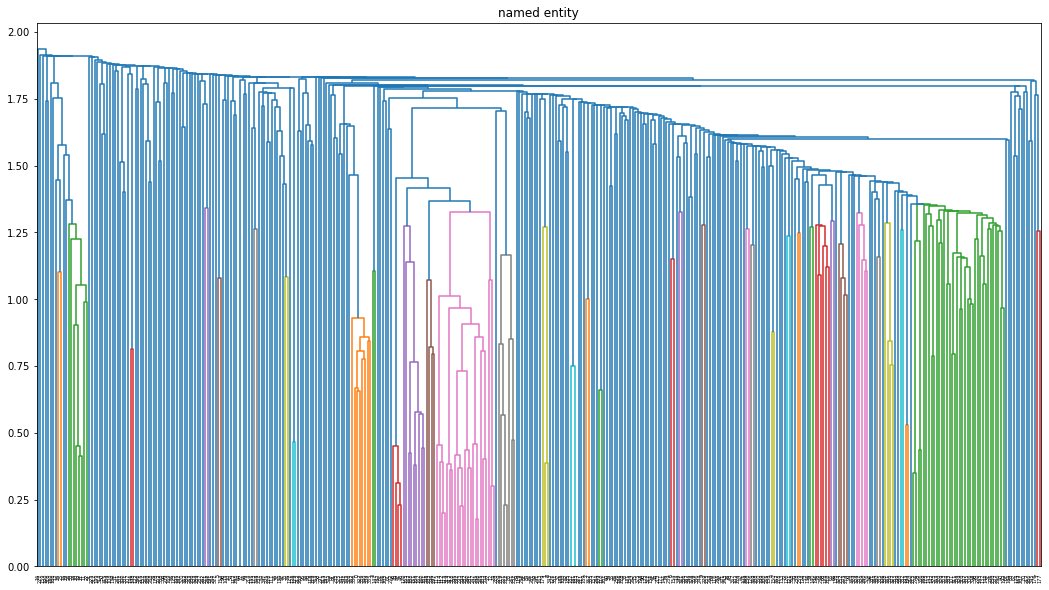

In [405]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# ユークリッド距離と群平均法を使用してクラスタリング
z = linkage(distance_matrix, metric='euclidean', method='single')

# 結果を可視化
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(1, 1, 1, title="named entity")
dendrogram(z)
plt.show()

In [413]:
from scipy.cluster.hierarchy import fcluster

# クラスタ数を指定してクラスタリング
cluster_result = []
clusters = fcluster(z, 1.3, criterion='distance')
for i, c in enumerate(clusters):
    cluster_result.append((new_named_entity_list[i], c))

In [414]:
import csv

with open('/Users/taroaso/myprojects/OpenIE/wiki-research-l/output/entity_cluster_result.csv', 'w') as f:
    writer = csv.writer(f)
    for result in cluster_result:
        writer.writerow(result)

In [305]:
#kb_df = pd.read_csv('/Users/taroaso/myprojects/OpenIE/wiki-research-l/output/full_replaced_triple_from_text_part.csv',index_col=0)
rows = []
triples = []
for row in kb_df.values:
    sbj = row[5].split()
    obj = row[7].split()
    for word in sbj:
        if word in named_entity_list:
            rows.append(row)
            triple = (word, 'seeAlso', row[5])
            triples.append(triple)
    for word in obj:
        if word in named_entity_list:
            rows.append(row)
            triple = (word, 'seeAlso', row[7])
            triples.append(triple)
minie_linked_triple_from_text_part = pd.DataFrame(rows, columns=['message_id','sentence', 'arg1', 'rel', 'arg2s','new_arg1','new_rel','new_arg2s'])
minie_linked_triple_from_text_part.to_csv('wiki-research-l/output/minie_linked_triple_from_text_part.csv')

In [306]:
print(len(triples))
triples = set(triples)
print(len(triples))

238
98


In [310]:
triple_df = pd.DataFrame(triples, columns=['subject','predicate','object'])
triple_df.to_csv('wiki-research-l/output/seealso_triples.csv')

In [136]:
# MinIEにかける
import requests
import json

extractions_list = []
for i,sentence in sentence_df['sentence'].items():
    try:
        response = requests.post('http://localhost:8080/minie/query', data=sentence)
        result = response.json()
        if result['facts'] == []:
            pass
        else:
            for triple in result['facts']:
                extractions_list.append([sentence_df['Message-ID'][i], sentence, triple['subject'], triple['predicate'], triple['object']])
    except Exception:
        pass

['<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>',
 'Thanks for your reply!',
 'your',
 'has',
 'reply']
555


In [137]:
# 整形結果をdataframeにする
kb_df = pd.DataFrame(extractions_list, columns = ['message_id','sentence', 'arg1', 'rel', 'arg2s'])
kb_df.head()
# dataframeをcsv出力する
kb_df.to_csv('wiki-research-l/output/minie_triple_from_text_part.csv')

# dataframeをRDBのテーブルにする
#from db import connect
#engine = connect()
#kb_df.to_sql(name='kb_wiki_research_l_text',con=engine,if_exists='replace',index=None)

In [138]:
# triple中の代名詞youの候補の辞書を作るために，Greetingsの行からYouの候補を取り出す．

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

you = {}
for mail in bodies['Bodies']:
    idx = mail['idx']
    for greetings in mail['Greetings']:
        doc = nlp(greetings[0])
        you[idx] = [(X.text, X.label_) for X in doc.ents if X.label_ not in ['DATE','TIME','PERCENT','MONEY','QUANTITY','ORDINAL','CARDINAL']]
        if you[idx] == []:
            del you[idx]

In [25]:
# tripleのI, MY, ME, WE, OUR, USの代名詞をSenderに置き換えるための辞書
refer_you = {}
for idx, candidate in you.items():
    message_id = mail_df["Message-ID"][idx]
    refer_you[message_id] = {"YOU":candidate[0][0], "YOUR":candidate[0][0] + '\'s'}

# tripleのI, MY, ME, WE, OUR, USの代名詞をSenderに置き換えるための辞書
refer_pronoun = {}
for row in kb_df.values:
    message_id = row[0]
    sender = mail_df[mail_df['Message-ID']==message_id]['From'].values[0]
    start = re.search(r'(\(.+\))',sender).start()
    end = re.search(r'(\(.+\))',sender).end()
    sender = sender[start+1:end-1]
    refer_pronoun[message_id]={'I':sender, 'MY':sender + '\'s', 'ME':sender, 'WE':sender, 'OUR':sender + '\'s', 'US':sender}

# 2つの辞書を結合する
for key, value in refer_you.items():
    if key in refer_pronoun:
        d = refer_pronoun[key]
        d.update(value)
        refer_pronoun[key] = d
    else:
        refer_pronoun[key] = value

NameError: name 'you' is not defined

In [140]:
# Senderに置き換えるための辞書を使って実際に置き換える
replaced_rows = []
for row in kb_df.values:
    message_id = row[0]
    arg1 = row[2].split()
    rel = row[3].split()
    arg2s = row[4].split()
    replaced = []
    # arg1の置き換え
    for i, word in enumerate(arg1):
        sender = refer_pronoun[message_id].get(word.upper())
        if sender is None:
            continue
        else:
            arg1[i] = sender
    new_arg1 = ' '.join(arg1)
    replaced.append(new_arg1)
    # relの置き換え
    for i, word in enumerate(rel):
        sender = refer_pronoun[message_id].get(word.upper())
        if sender is None:
            continue
        else:
            rel[i] = sender
    new_rel = ' '.join(rel)
    replaced.append(new_rel)
    # arg2sの置き換え
    for i, word in enumerate(arg2s):
        sender = refer_pronoun[message_id].get(word.upper())
        if sender is None:
            continue
        else:
            arg2s[i] = sender
    new_arg2s = ' '.join(arg2s)
    replaced.append(new_arg2s)
    # [new_arg1, new_rel, new_arg2s]を1行として追加
    replaced_rows.append(replaced)

In [141]:
replaced_triples = pd.DataFrame(replaced_rows,columns=['new_arg1','new_rel','new_arg2s'])
kb_df = pd.concat([kb_df, replaced_triples],axis=1)
kb_df.to_csv('/Users/taroaso/myprojects/OpenIE/wiki-research-l/output/minie_triple_from_text_part.csv')

In [ ]:
from entityLinking import tagme, confidentAnnotations, mediaWiki

entity_list = []
for i, sentence in sentence_df['sentence'].items():
    json_res = tagme(sentence)
    for candidate in json_res['annotations']:
        if candidate['rho'] >= 0.3:
            entity_list.append([i, candidate['spot'],candidate['rho'],candidate['id'],candidate['title']])
        else:
            continue

# 抽出したentityをdataframeに格納する
rows = []
for row in entity_list:
    rows.append([sentence_df['Message-ID'][row[0]], row[1], row[2], row[3], row[4]])
entity_df = pd.DataFrame(rows,columns=['Message-ID','spot','rho','id','title'])
entity_df.head()

In [ ]:
#entity_df = pd.read_csv('wiki-research-l/output/entity_df.csv', index_col=0)
entity_df[entity_df['rho'] < 0.3][0:100]

In [312]:
thread_df.head()

,file_path,Message-ID,In-Reply-To,References
0,wiki-research-l/2020-July/2020-July-00,<CAE4fJj-un1Um+3aE1jTe9b8WQZuFLMaaFmCJ9zNtzTkuUja0Rw@mail.gmail.com>,<CACP3XfoFBFyM1Ft1EMeiceaQhOMR_62ytHn_pbdDtd02v9wedQ@mail.gmail.com>,<CAE4fJj8bAoCLbs56g8fMo5Ek7GFk1h15ZhSJ7wy3h_KxLxhmTw@mail.gmail.com>\n <CACP3XfoFBFyM1Ft1EMeiceaQhOMR_62ytHn_pbdDtd02v9wedQ@mail.gmail.com>
1,wiki-research-l/2020-July/2020-July-01,<CAE4fJj_b7k8yeqmz19a-seo3gtL9Mg1nvQO0oPUtrxvCFMkEaw@mail.gmail.com>,<CAKnkOD6AxZEq1UskakLUcR56znC=7AgBA3mtxU0LSjuUC-rtUg@mail.gmail.com>,<CAE4fJj8bAoCLbs56g8fMo5Ek7GFk1h15ZhSJ7wy3h_KxLxhmTw@mail.gmail.com>\n <CAKnkOD7suYBmXXta6Dr7_QUBXDW7Ykyve2gmYUS36KiErokSRw@mail.gmail.com>\n <CAE4fJj-19e00ZzXA+KRqpfsn5kgFUTkPA93fm-tO_C-BOkbmyA@mail.gmail.com>\n <CAKnkOD6AxZEq1UskakLUcR56znC=7AgBA3mtxU0LSjuUC-rtUg@mail.gmail.com>
2,wiki-research-l/2020-July/2020-July-02,<CAFw=MpJg9SYEGQD9ywhphWwwNE8fHHcsSEHne8=B-8S0w+o=Kg@mail.gmail.com>,None,None
3,wiki-research-l/2020-July/2020-July-03,<1395374715.4530653.1593904473385@mail.yahoo.com>,None,<1395374715.4530653.1593904473385.ref@mail.yahoo.com>
4,wiki-research-l/2020-July/2020-July-04,<CALeA2c9GW9BFSMetuSCDWLbm2iGG1xM7Bp0R2A9-JJF2_7Xrwg@mail.gmail.com>,None,None
